In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gp
import numpy as np
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon , mapping
import matplotlib.pyplot as plt
from rasterio.plot import show
import pyproj
from pyproj import CRS
import fiona
import os 
import re
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyproj import transform
from pyproj import Proj
import ast
import pandas as pd

In [2]:
from IPython.display import Audio, display
from timeit import default_timer as timer
start = timer()
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
def alert():
  global start
  end= timer()
  print("\n\nDuration in minutes : " +  str((end - start)/60) + " minutes." )
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [3]:
os.listdir('./data/Satellite_Images') # indexes of fires of images founded

['index12129', 'index20109', 'index22681']

In [4]:
index = '20109' # index of fire 
os.listdir('./data/Satellite_Images/index'+ index) # images founded for index choosen

['S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.zip',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TNF_20150903T112534',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TNF_20150903T112534.zip',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TPE_20150903T112534',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TPE_20150903T112534.zip',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TPF_20150903T112534',
 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TPF_20150903T112534.zip']

In [5]:
# IMAGE NAME
img_data_id = 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534' # good image, cant see fire
#img_data_id = 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TNF_20150903T112534' # clouds
#img_data_id = 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TPE_20150903T112534' # good image, cant see fire
#img_data_id = 'S2A_MSIL1C_20150903T112116_N0204_R037_T29TPF_20150903T112534' # clouds

# Fires data

In [6]:
fires = pd.read_csv("./data/Fires_data/incendios2015.csv", sep=';' , encoding="utf-8",na_values="nan")
incendio = fires['incendio']==1
falso_alarme = fires['falso_alarme']==0 
falso_alarme_tipo = fires['tipo']!='Falso Alarme'
fogacho = fires['fogacho']==0
fires = fires[ incendio & falso_alarme & falso_alarme_tipo & fogacho]
fires.drop([
               'ano', 
               'codigo_sgif',
               'codigo_anpc',
               'data_primeira_intervencao',
               'hora_primeira_intervencao',
               'fonte_alerta',
               'nut',
               'ine',
               'causa', 'reacendimento' , 'agricola',
               'queimada','falso_alarme','fogacho','incendio','perimetro','aps', 'regiao_prof', 'ugf' 
          ],axis=1, inplace=True)
fires = fires.sort_values('area_total',  ascending=False)
fires.dropna()
fires.head()

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tipo,distrito,concelho,freguesia,local,x,y,lat,lon,data_alerta,hora_alerta,data_extincao,hora_extincao,area_povoamento,area_mato,area_agricola,area_pov_mato,area_total,tipo_causa
21390,Florestal,Viseu,Mangualde,PÃ³voa de CervÃ£es,ContenÃ§as de Baixo,237389.0,398832.0,40:33:26.5068000000082'',7:41:29.922000000001'',06/08/2015,15:59:00,07/08/2015,07:33:00,29.89,955.11,0,985,985,NaN
6551,Florestal,Guarda,MÃªda,Ranhados,Pinhal das Forcas,267527.0,448034.0,40:59:54.643199999993'',7:19:49.9692000000005'',30/06/2015,14:34:00,01/07/2015,00:00:00,55.50,35,7.5,90.5,98,Intencional
7081,Florestal,Viseu,Armamar,SÃ£o Cosmado,Regadas,241299.0,454999.0,41:3:47.069999999992'',7:38:30.4511999999989'',30/03/2015,14:30:00,31/03/2015,02:54:00,24.85,72.89,0,97.74000000000001,97.74,Negligente
3947,Florestal,Castelo Branco,CovilhÃ£,Verdelhos,Sernadas,252322.0,375942.0,40:21:2.06999999999709'',7:31:2.07479999999883'',31/03/2015,09:18:00,01/04/2015,04:04:00,0.00,97.404,0,97.404,97.404,Negligente
21637,Florestal,Braga,GuimarÃ£es,SÃ£o Torcato,BOAVISTA,189451.0,501843.0,41:29:9.29040000000384'',8:15:34.1676000000021'',09/08/2015,11:20:00,10/08/2015,03:33:00,70.00,27,0,97,97,Desconhecida


In [7]:
fires.loc[ int(index) , : ]

tipo                              Florestal
distrito                     Castelo Branco
concelho                           CovilhÃ£
freguesia                Aldeia do Carvalho
local                       CovÃ£o do Teixo
x                                    251685
y                                    372820
lat                40:19:20.8667999999966''
lon                 7:31:29.7119999999994''
data_alerta                      04/09/2015
hora_alerta                        11:48:00
data_extincao                    04/09/2015
hora_extincao                      13:20:00
area_povoamento                           0
area_mato                             9.489
area_agricola                             0
area_pov_mato                         9.489
area_total                            9.489
tipo_causa                       Negligente
Name: 20109, dtype: object

# Fires images

In [8]:
# path to jp2 files
path = './data/Satellite_images/index' + index + '/' + img_data_id + '/' + img_data_id + '.SAFE/IMG_DATA/'
path
os.listdir(path)

['T29TNE_20150903T112116_B01.jp2',
 'T29TNE_20150903T112116_B02.jp2',
 'T29TNE_20150903T112116_B03.jp2',
 'T29TNE_20150903T112116_B04.jp2',
 'T29TNE_20150903T112116_B05.jp2',
 'T29TNE_20150903T112116_B06.jp2',
 'T29TNE_20150903T112116_B07.jp2',
 'T29TNE_20150903T112116_B08.jp2',
 'T29TNE_20150903T112116_B09.jp2',
 'T29TNE_20150903T112116_B10.jp2',
 'T29TNE_20150903T112116_B11.jp2',
 'T29TNE_20150903T112116_B12.jp2',
 'T29TNE_20150903T112116_B8A.jp2',
 'T29TNE_20150903T112116_TCI.jp2']

In [9]:
regexp = re.compile(r'_B0[2348]')
sentinal_band_paths = [os.path.join(path, f) for f in os.listdir(path) if regexp.search(f) ]
sentinal_band_paths.sort()
sentinal_band_paths

['./data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T29TNE_20150903T112116_B02.jp2',
 './data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T29TNE_20150903T112116_B03.jp2',
 './data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T29TNE_20150903T112116_B04.jp2',
 './data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T29TNE_20150903T112116_B08.jp2']

In [10]:
for i in sentinal_band_paths : 
        src = rasterio.open(i,driver='JP2OpenJPEG')
        meta = src.meta
        print( i + " ::: ")
        print(meta)

./data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T29TNE_20150903T112116_B02.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 4500000.0)}
./data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T29TNE_20150903T112116_B03.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 4500000.0)}
./data/Satellite_images/index20109/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534/S2A_MSIL1C_20150903T112116_N0204_R037_T29TNE_20150903T112534.SAFE/IMG_DATA/T

In [11]:
img_dir = './data/Satellite_images/index'+ index + '/'+ img_data_id + "/"

if not os.path.exists(img_dir):
    os.makedirs(img_dir)

img_fp = img_dir + 'bands_img_data_' + index +  '.tif'

if ( not os.path.isfile(img_fp) ):
    # Read metadata of first file and assume all other bands are the same
    with rasterio.open(sentinal_band_paths[0], driver='JP2OpenJPEG') as src0:
        meta = src0.meta

    # Update metadata to reflect the number of layers
    meta.update(count = len(sentinal_band_paths))

    # Read each layer and write it to stack
    with rasterio.open(img_fp, 'w', **meta) as dst:
        for id, layer in enumerate(sentinal_band_paths, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

In [12]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(10980, 10980)
4


In [13]:
with rasterio.open(img_fp) as src:
    img = src.read()[:,  :  ,   :  ]

### Cutting images for faster process

In [14]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init= full_dataset.crs  )

#fire location
x1 = -7.52492
y1 = 40.322463

x2,y2 = transform(inProj,outProj,x1,y1)
print (x2,y2)

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


625320.3890905925 4464592.457732637


In [15]:
print(type(full_dataset.transform))
a = full_dataset.transform

# x, y to col, row
col, row = ~a * ( x2 , y2 )

print(col,row)


<class 'affine.Affine'>
12534.03890905925 3540.7542267362587


In [18]:
# 0 to  10980 for this img_data

xmin = int( col - 2000 )  # 6700
xmax = int( col + 200 )#7000
ymin = int( row - 200 )# 6600
ymax = int( row + 200 )# 6900

if (xmin < 0) :
    xmin = 0
if (ymin < 0) :
    ymin = 0
if (xmax > 10980) :
    xmax = 10980
if (ymax > 10980) :
    ymax = 10980


print ( xmin , xmax ,  ymin , ymax )

10534 10980 3340 3740


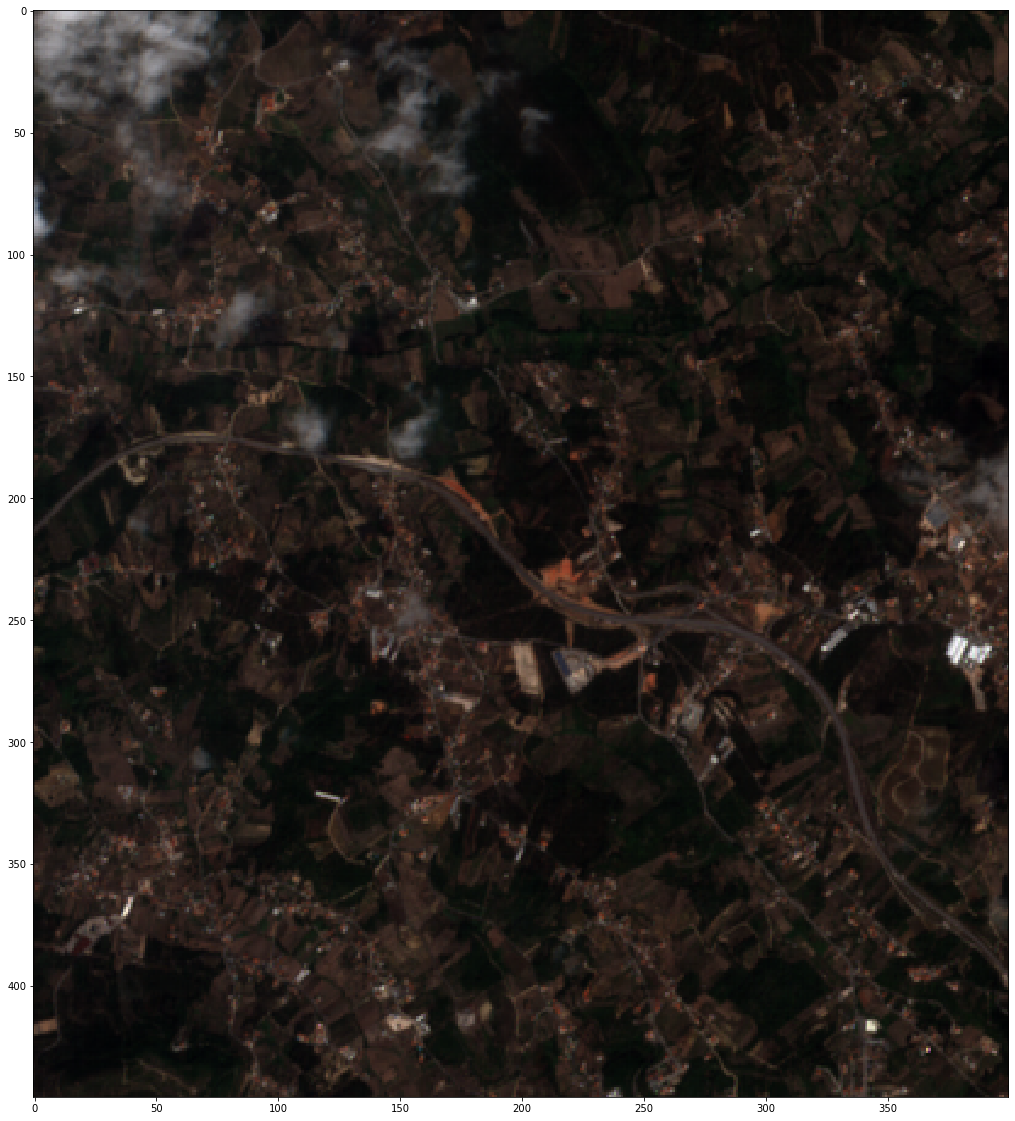

In [19]:
img_train = img[:, xmin : xmax ,  ymin : ymax ]
reshaped_img_train = reshape_as_image(img_train)

fig, axs = plt.subplots(1,figsize=(20,20))
img_stretched_train = color_stretch(reshaped_img_train, [2, 1, 0])
axs.imshow(img_stretched_train)

In [20]:
alert() # audio alert



Duration in minutes : 8.514404598333334 minutes.
